In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message="You are using `torch.load` with `weights_only=False`")
warnings.filterwarnings("ignore", category=UserWarning, message="The PyTorch API of nested tensors is in prototype stage and will change in the near future.")

%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0,"/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre")
            
import torch
torch.set_printoptions(precision=10)


import yaml
torch.set_float32_matmul_precision('medium')
from pathlib import Path

from rdkit import Chem
from rdkit.Chem import Draw
# load model 
from datasets.dataset_utils import fp_loader_configer

fp_loader_configer.select_version("MFP_Specific_Radius")
specific_radius_mfp_loader = fp_loader_configer.fp_loader

import pickle     

import numpy as np 
import random
seed=2
torch.cuda.manual_seed_all(seed) 
np.random.seed(seed)
random.seed(seed)


choosing Specific_Radius_MFP_loader


In [4]:
with open(f'/root/gurusmart/MorganFP_prediction/inference_data/coconut_loutus_hyun_training/inference_metadata_latest_RDkit.pkl', 'rb') as file:
    smiles_and_names = pickle.load(file)
print(len(smiles_and_names))

526316


In [5]:
from inference.inference_utils import choose_model
from inference.inference_utils import save_molecule_inference
from inference.inference_utils import retrieve_top_k_by_rankingset, compute_cos_sim, unpack_inputs_no_delimiter, build_input, inference_topK
from utils.get_NP_class import get_superclass_and_glycoside

In [21]:
#### For infrastructure, 
#### run this:
# hparams, model  = choose_model("C-NMR", include_test_loader = False)


hparams, model , test_loader = choose_model("HSQC", shuffle_loader=True)

max_radius = specific_radius_mfp_loader.max_radius




Normal
max_radius:  4


Initialized SignCoordinateEncoder[784] with dims [365, 365, 54] and 2 positional encoders. 54 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args


In [8]:
hparams['FP_building_type'].split("_")[-1]

'Normal'

In [9]:
model.device

device(type='cuda', index=0)

In [10]:
rankingset_path = f"/root/gurusmart/MorganFP_prediction/inference_data/inference_rankingset_with_stable_sort/max_radius_{max_radius}_stacked_together_sparse/FP.pt"

rankingset_data = torch.load(rankingset_path)#.to("cuda")



/opt/conda/lib/python3.11/site-packages/torch/_utils.py:315: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  result = torch.sparse_compressed_tensor(


In [11]:
rankingset_data = rankingset_data.to(model.device)
len(rankingset_data), len(smiles_and_names)

(526316, 526316)

In [12]:
"""
For comparing deepsat vs spectre, we construct input for deepsat
"""
pth = "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/datasets/test_indices_of_full_info_NMRs.pkl"
with open(pth, 'rb') as file:
    test_indices_of_full_info = pickle.load(file)
test_indices_of_full_info.sort()
torch_file_to_loader_idx = {n:i for i, n in enumerate(test_indices_of_full_info)}
loader_idx_to_torch_file = {i:n for i, n in enumerate(test_indices_of_full_info)}


In [13]:
torch_file_to_loader_idx["8886.pt"]

3728

In [14]:
from inference.inference_utils import convert_hsqc_tensort_to_txt


In [15]:

hyunwoo_retrieve_data_path = "/root/gurusmart/MorganFP_prediction/inference_data/hyunwoo_retrieval_data/SMILES_and_Names.pkl"
with open(hyunwoo_retrieve_data_path, 'rb') as file:
    hyunwoo_retrieve_data = pickle.load(file) 

In [16]:
hyunwoo_retrieve_smiles = set([x[0] for x in hyunwoo_retrieve_data])
len(hyunwoo_retrieve_smiles)

196665

In [41]:
hyunwoo_retrieve_smiles

{'O=C(O)Cc1c(F)cccc1Cl',
 'CC1=CC(=O)C2(O)CC(C)(O)C1C21Oc2cc(C)cc(O)c2O1',
 'C=C1C(=O)C23CCC4C(C(=O)OC)CC(OC(=O)C5OC(c6ccccc6)=NC5c5ccccc5)CC4(C)C2CCC1C3',
 'CC1(C)CCCC2(C)C1CCC13C=CC(CO)(C1)C(O)CC32',
 'COC(=O)c1c(O)cc(O)cc1Oc1c(O)c(CC=C(C)C)c(CC=C(C)C)c(OC)c1OC',
 'CCOCC1(O)C(=O)C=C2C(COC(=O)CC(C)C)=COC(OC(=O)CC(C)C)C21',
 'CC1C=CC2CC(C)(O)CCC2C1(C)C(=O)CCO',
 'C=C1CCCC2(C)Cc3occ(C)c3C(OC(C)=O)C12',
 'COC(=O)C(C)C1=CC=C(C)CCC=C(C)CCC=C(C)CC1',
 'CC(C)C1(OO)CC2(C)C(C)CCC(=O)C2CC1=O',
 'CC1OC(OC2CC3C(=CCC4(C)C(=O)CCC34)C3(C)CCC(OS(=O)(=O)[O-])CC23)C(O)C(O)C1OS(=O)(=O)[O-].[Na+]',
 'CCC(C)C(=O)OC1C(O)C2(COC(C)=O)C(CC1(C)C)C1=CCC3C4(C)CCC(OC5OC(COC6OCC(O)C(O)C6O)C(O)C(O)C5OC5OC(CO)C(O)C(O)C5O)C(C)(C)C4CCC3(C)C1(C)C(O)C2O',
 'COc1cc(C(=O)CCOC(C)=O)cc(O)c1OC',
 'C=C1C(=O)OC2C=C(C)C(OC(C)=O)CC=C(C)CC(OC(=O)C(=CCOC(C)=O)COC(C)=O)C12',
 'CC(C)C1CCC2(CO)CCC3(C)CC(O)C4(C)CC4C3C12',
 'COc1cc2oc(=O)cc(COC(=O)C=C(C)C)c2cc1OC',
 'OCCCCCCCCCCCCCCCCCCCCCCO',
 'COc1cc(C2OC(O)C3C(c4ccc(O)c(OC)c4)OC(O)C

NP class: Sesquiterpenoids, MW: 220.1826934814453
Ground Truth NMR
MW filter: [176.14615478515626, 264.21923217773434]
Chemical name 12302845
Ground truth smiles C=C1CCCC(C)(C)C12CC=C(CO)CC2


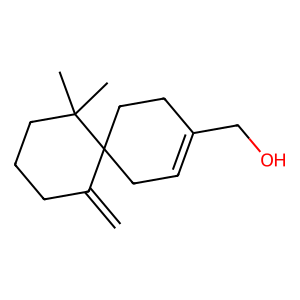

Prediction's cosine similarity to ground truth:  0.9435943365097046
idx is  0
________CORRECT ___


NP class: Meroterpenoids, MW: 462.180908203125
Ground Truth NMR
MW filter: [369.74472656250003, 554.61708984375]
Chemical name chrodrimanin K
Ground truth smiles CC1Cc2c3c(c(Cl)c(O)c2C(=O)O1)OC1(C)C(O)CC2C(C)(C)C(=O)CCC2(C)C1C3


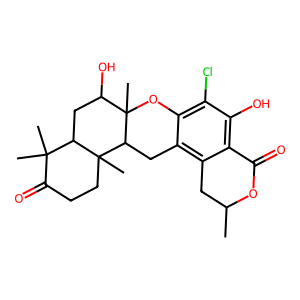

Prediction's cosine similarity to ground truth:  0.8731417059898376
idx is  1
________retival #1, cosine similarity to prediction: 0.8897688984870911_________________
SMILES: CC1Cc2c3c(cc(O)c2C(=O)O1)OC1(C)C(O)CC2C(C)(C)C(=O)CCC2(C)C1C3
Name thailandolide A
Molecular weight 428.52500000000015


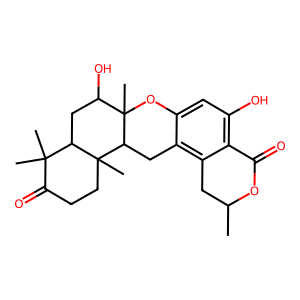

NP class: Linear polyketides, MW: 556.3400268554688
Ground Truth NMR
MW filter: [445.072021484375, 667.6080322265625]
Chemical name 92090-94-3
Ground truth smiles CCC(C=CC1OC(=O)C=CC1C)=CC(C)CC=CC(C)=CC(CO)C(=O)C(C)C(O)C(C)CC(C)=CC(=O)O


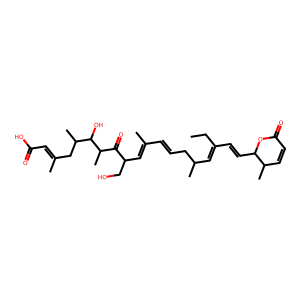

Prediction's cosine similarity to ground truth:  0.8264817595481873
idx is  3
________retival #1, cosine similarity to prediction: 0.8286392092704773_________________
SMILES: CCC(C=CC1OC(=O)C=CC1C)=CC(C)CC=CC(C)=CC(C)C(=O)C(C)C(O)C(C)CC(C)=CC(=O)O
Name leptomycin B
Molecular weight 540.7410000000002


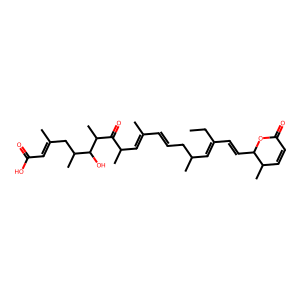

NP class: Oligopeptides, MW: 1561.81396484375
Ground Truth NMR
MW filter: [1249.451171875, 1874.1767578125]
Chemical name SCHEMBL12646635
Ground truth smiles CC(C)CCCC1CC(=O)NC(CO)C(=O)NC(C(O)C(N)=O)C(=O)NC(CO)C(=O)NCC(=O)N(C)C(Cc2ccccc2)C(=O)NC(CC(C)C)C(=O)NC(CCCN)C(=O)NC(CCC(=O)O)C(=O)NC(CC(N)=O)C(=O)NC(Cc2c[nH]c3ccccc23)C(=O)NC(CCCN)C(=O)N(C)C(C(C)C)C(=O)O1


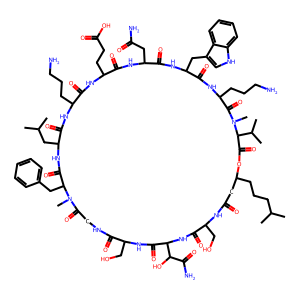

Prediction's cosine similarity to ground truth:  0.9889203310012817
idx is  4
________retival #1, cosine similarity to prediction: 0.990084707736969_________________
SMILES: CC(C)CCCCC1CC(=O)NC(CO)C(=O)NC(C(O)C(N)=O)C(=O)NC(CO)C(=O)NCC(=O)N(C)C(Cc2ccccc2)C(=O)NC(CC(C)C)C(=O)NC(CCCN)C(=O)NC(CCC(=O)O)C(=O)NC(CC(N)=O)C(=O)NC(Cc2c[nH]c3ccccc23)C(=O)NC(CCCN)C(=O)N(C)C(C(C)C)C(=O)O1
Name WAP-8294A4
Molecular weight 1576.816


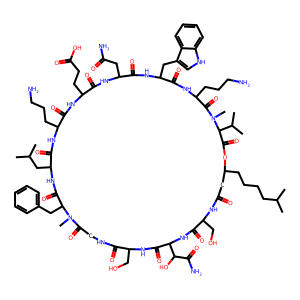

NP class: Triterpenoids, MW: 468.3240051269531
Ground Truth NMR
MW filter: [374.6592041015625, 561.9888061523437]
Chemical name Ochraceolide E
Ground truth smiles C=C1C(=O)OC2CC3(CO)CCC4(C)C(CCC5C6(C)CCC(=O)C(C)(C)C6CCC54C)C3C12


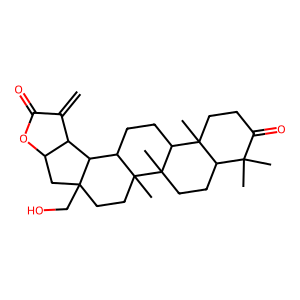

Prediction's cosine similarity to ground truth:  0.9250255227088928
idx is  11
________CORRECT ___


NP class: Tryptophan alkaloids, MW: 412.3089904785156
Ground Truth NMR
MW filter: [329.8471923828125, 494.7707885742187]
Chemical name ircinol A
Ground truth smiles OCC1=CC2(O)CCC=CCCCCN3CCC1C1(CC4C=CCCCCN4C21)C3


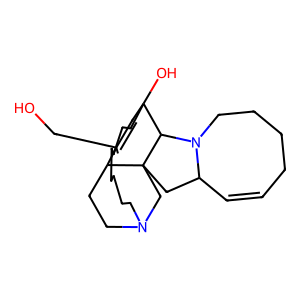

Prediction's cosine similarity to ground truth:  0.8812557458877563
idx is  15
________retival #1, cosine similarity to prediction: 0.8913816809654236_________________
SMILES: O=CC1=CC2(O)CCC=CCCCCN3CCC1C1(CC4C=CCCCCN4C21)C3
Name ircinal A
Molecular weight 410.6020000000002


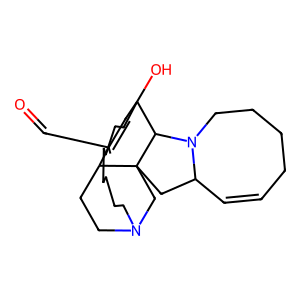

NP class: Flavonoids, MW: 400.07940673828125
Ground Truth NMR
MW filter: [320.06352539062505, 480.09528808593745]
Chemical name 73818214
Ground truth smiles O=c1cc(C2Oc3cc(O)cc(O)c3CC2O)cc2cc(O)c(O)c(O)c2c1O


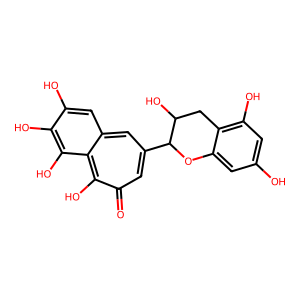

Prediction's cosine similarity to ground truth:  0.804350733757019
idx is  18
________retival #1, cosine similarity to prediction: 0.8127185106277466_________________
SMILES: O=c1oc2c(O)cc(C3Oc4cc(O)cc(O)c4CC3O)cc2c2c(O)c(O)c(O)cc12
Name amurensisin
Molecular weight 440.3600000000002


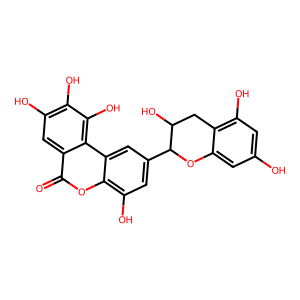

NP class: Steroids, MW: 412.3705139160156
Ground Truth NMR
MW filter: [329.89641113281255, 494.8446166992187]
Chemical name 23SH-5a-isocalystanol
Ground truth smiles CC1=C(C(C)C)C1CC(C)C1CCC2C3CCC4CC(O)CCC4(C)C3CCC12C


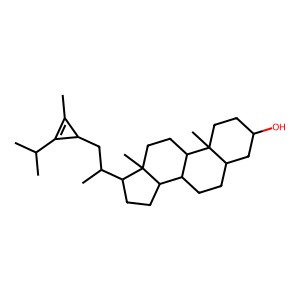

Prediction's cosine similarity to ground truth:  0.934024453163147
idx is  20
________retival #1, cosine similarity to prediction: 0.9613004922866821_________________
SMILES: CC(C)C1=C(CC(C)C2CCC3C4CCC5CC(O)CCC5(C)C4CCC23C)C1C
Name 123238-74-4
Molecular weight 412.7020000000002


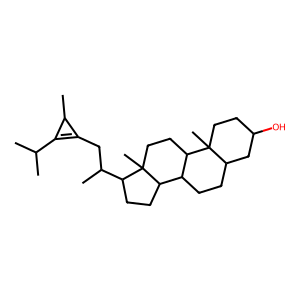

NP class: Diterpenoids, MW: 384.1664123535156
Ground Truth NMR
MW filter: [307.3331298828125, 460.99969482421875]
Chemical name (1R,4S,5S,8R,9S,10S,12S,14R)-5-Bromo-14-isopropyl-4,8-dimethyltetracyclo[10.2.1.0~1,10~.0~4,9~]pentadecane-8,14-diol
Ground truth smiles CC(C)C1(O)CC2CC3C4C(C)(O)CCC(Br)C4(C)CCC31C2


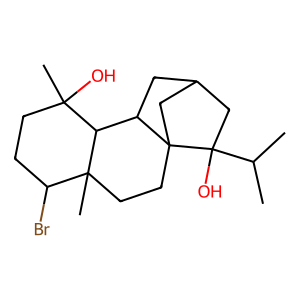

Prediction's cosine similarity to ground truth:  0.5842723250389099
idx is  27
________retival #1, cosine similarity to prediction: 0.8056298494338989_________________
SMILES: CC1C(=O)C23CCC4C(C)(C(=O)O)CCCC4(C)C2C(O)CC1C3
Name 59906-18-2
Molecular weight 334.456


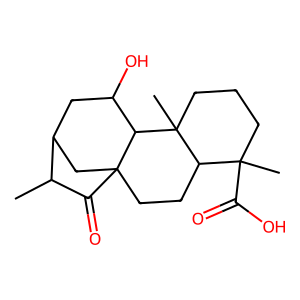

NP class: Small peptides, MW: 254.1378936767578
Ground Truth NMR
MW filter: [203.31031494140626, 304.96547241210936]
Chemical name 7408625
Ground truth smiles CC(C)C(N)C(=O)NC(Cc1cnc[nH]1)C(=O)O


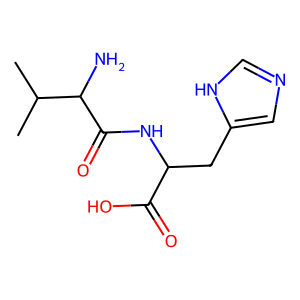

Prediction's cosine similarity to ground truth:  0.9805864095687866
idx is  28
________CORRECT ___


NP class: Aromatic polyketides, MW: 526.3294067382812
Ground Truth NMR
MW filter: [421.06352539062505, 631.5952880859375]
Chemical name Oncostemonol F
Ground truth smiles CC(=O)Oc1cc(O)cc(CCCCCCCCCCCCCCCCc2cc(O)cc(OC(C)=O)c2)c1


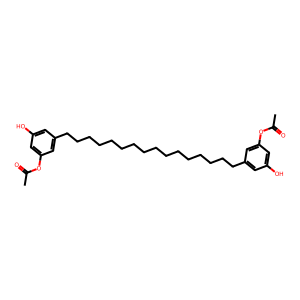

Prediction's cosine similarity to ground truth:  0.9101859927177429
idx is  32
________CORRECT ___


NP class: Monoterpenoids, MW: 244.14630126953125
Ground Truth NMR
MW filter: [195.31704101562502, 292.9755615234375]
Chemical name 68233-94-3
Ground truth smiles COc1cc2c(C)c(O)cc(C(C)C)c2cc1C


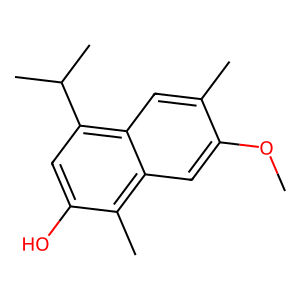

Prediction's cosine similarity to ground truth:  0.8756319880485535
idx is  34
________CORRECT ___


NP class: Coumarins, MW: 264.04229736328125
Ground Truth NMR
MW filter: [211.233837890625, 316.8507568359375]
Chemical name CHEBI:5179
Ground truth smiles O=c1oc2ccccc2c2oc3ccccc3c(=O)c12


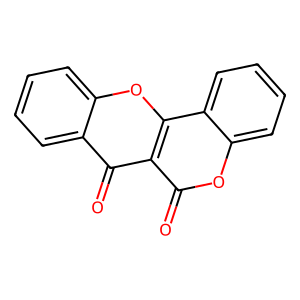

Prediction's cosine similarity to ground truth:  0.7372948527336121
idx is  48
________retival #1, cosine similarity to prediction: 0.87210613489151_________________
SMILES: O=c1c2ccccc2oc2cc(O)c(O)cc12
Name "2,3-dihydroxyxanthen-9-one"
Molecular weight 228.20299999999997


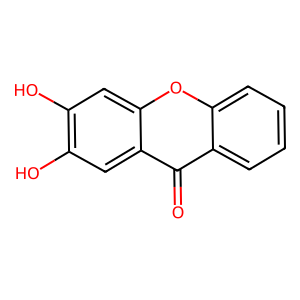

NP class: Isoflavonoids, MW: 300.09979248046875
Ground Truth NMR
MW filter: [240.079833984375, 360.1197509765625]
Chemical name 124901-96-8
Ground truth smiles COc1ccc(C2=Cc3ccc(O)c(OC)c3OC2)c(O)c1


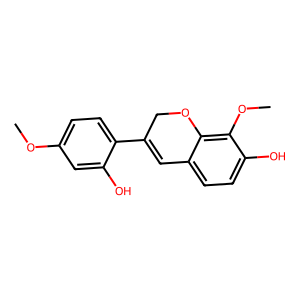

Prediction's cosine similarity to ground truth:  0.8495557308197021
idx is  49
________retival #1, cosine similarity to prediction: 0.9132715463638306_________________
SMILES: COc1c(O)ccc(C2=Cc3ccc(O)cc3OC2)c1OC
Name 3-(4-Hydroxy-2,3-Dimethoxyphenyl)-2H-Chromen-7-Ol
Molecular weight 300.31000000000006


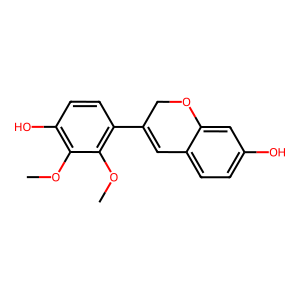

NP class: Lignans, MW: 344.1260070800781
Ground Truth NMR
MW filter: [275.3008056640625, 412.9512084960937]
Chemical name 155759-04-9
Ground truth smiles COc1cc(C2Oc3c(O)cc(C=CCO)cc3C2CO)ccc1O


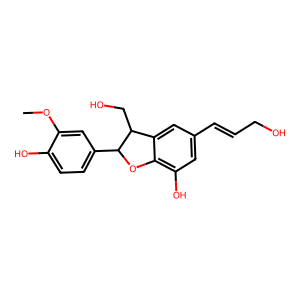

Prediction's cosine similarity to ground truth:  0.9575616717338562
idx is  50
________retival #1, cosine similarity to prediction: 0.9626630544662476_________________
SMILES: COc1cc(C2Oc3c(OC)cc(C=CCO)cc3C2CO)ccc1O
Name Dehydroconiferyl Alcohol
Molecular weight 358.3900000000001


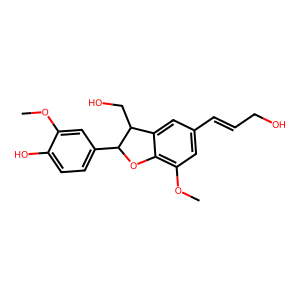

NP class: Polycyclic aromatic polyketides, MW: 526.1264038085938
Ground Truth NMR
MW filter: [420.901123046875, 631.3516845703125]
Chemical name 119026021
Ground truth smiles Cc1cc(O)c2c(c1)C(O)C13Cc4cc(O)c5c(c4C1C=CC(O)C3OC2=O)C(=O)c1cccc(O)c1C5=O


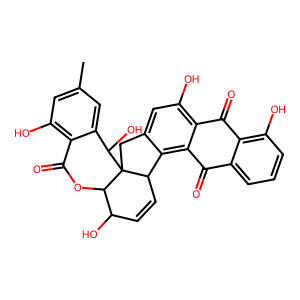

Prediction's cosine similarity to ground truth:  0.8691316246986389
idx is  61
________retival #1, cosine similarity to prediction: 0.9219820499420166_________________
SMILES: Cc1cc(O)c2c(c1)C(O)C13Cc4cc(O)c5c(c4C1C=CC(=O)C3=C2O)C(=O)c1cccc(O)c1C5=O
Name 71514049
Molecular weight 508.48200000000026


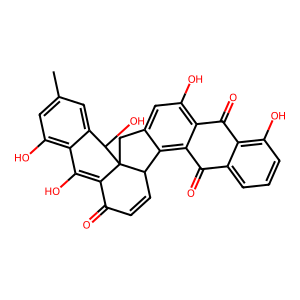

NP class: Cyclic polyketides, MW: 350.1882019042969
Ground Truth NMR
MW filter: [280.1505615234375, 420.22584228515626]
Chemical name Ceratioflavin A
Ground truth smiles CC=CCCC=CC=CC=CC=CC=CC=Cc1cc(OC)cc(=O)o1


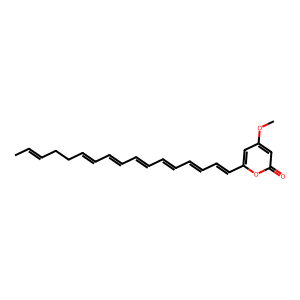

Prediction's cosine similarity to ground truth:  0.9269570112228394
idx is  119
________CORRECT ___


NP class: Macrolides, MW: 820.4608764648438
Ground Truth NMR
MW filter: [656.368701171875, 984.5530517578125]
Chemical name tartrolon D
Ground truth smiles CC1CCC=CC=CCCC(O)CC(=O)CC2CCC(C)C(O)(O2)C(O)C(=O)OC(C)CCC=CC=CCCC(O)CC(=O)CC2CCC(C)C(O)(O2)C(O)C(=O)O1


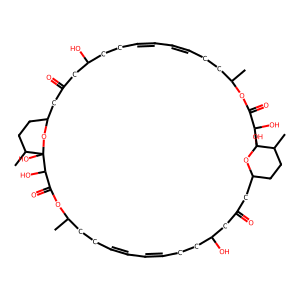

Prediction's cosine similarity to ground truth:  0.834712028503418
idx is  129
________retival #1, cosine similarity to prediction: 0.8876911401748657_________________
SMILES: CC1CCC=CC=CCCC(O)CC(=O)C(C)C2CCC(C)C(O)(O2)C(O)C(=O)OC(C)CCC=CC=CCCC(O)CC(=O)C(C)C2CCC(C)C(O)(O2)C(O)C(=O)O1
Name 156407-54-4
Molecular weight 849.0680000000001


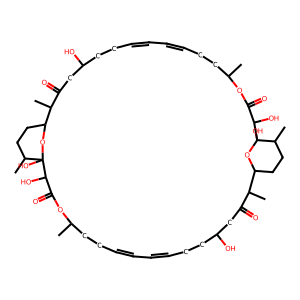

NP class: Pseudoalkaloids, MW: 393.2514953613281
Ground Truth NMR
MW filter: [314.6011962890625, 471.90179443359375]
Chemical name 113963-58-9
Ground truth smiles CCN1CC2(C)C(O)C(O)CC34C1C(CC23)C12CCC(CC41)C(O)(CO)C2O


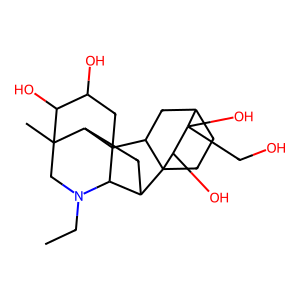

Prediction's cosine similarity to ground truth:  0.6571193337440491
idx is  138
________retival #1, cosine similarity to prediction: 0.6867271065711975_________________
SMILES: CCN1CC2(C)C(O)CCC34C1C(CC23)C12CCC(CC41)C(O)(CO)C2O
Name (1r,4r,5r,8r,9r,10r,11s,12r,13s,15s,16s)-7-ethyl-12-(hydroxymethyl)-5-methyl-7-azahexacyclo[7.6.2.2¹⁰,¹³.0¹,⁸.0⁵,¹⁶.0¹⁰,¹⁵]nonadecane-4,11,12-triol
Molecular weight 377.52500000000003


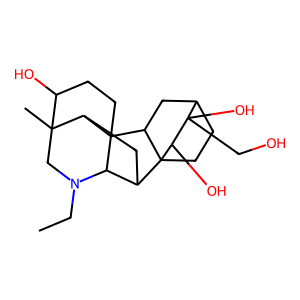

NP class: Tyrosine alkaloids, MW: 278.069091796875
Ground Truth NMR
MW filter: [222.4552734375, 333.68291015625]
Chemical name Hadranthine B
Ground truth smiles COc1c2c3c(ccnc3c3ccccc13)C(=O)C(=O)N2


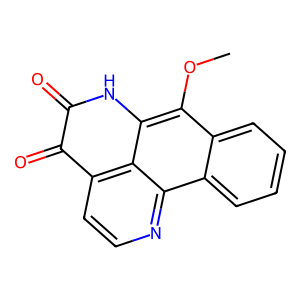

Prediction's cosine similarity to ground truth:  0.7849292159080505
idx is  147
________retival #1, cosine similarity to prediction: 0.8091176748275757_________________
SMILES: COc1c2c3c(ccnc3c3ccccc13)C(=O)C(=O)N2C
Name 7-Methoxy-6-methyl-4H-naphtho[1,2,3-ij][2,7]naphthyridine-4,5(6H)-dione
Molecular weight 292.29400000000004


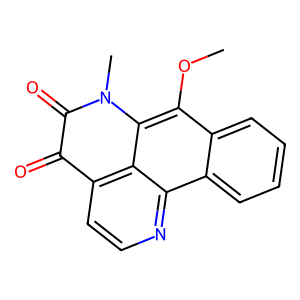

DONE






In [46]:
#### For infrastructure, this is cell can be skipped because i am not sharing my test-loader
'''
show one compound from each of the top 20 NP classes
'''

with open("/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/top_20_NP_classes.pkl", "rb") as f:
    top_20_NP_classes = pickle.load(f)
top_20_NP_classes = set(top_20_NP_classes)

counter_correct = 0
for idx, batch in enumerate(test_loader):
  
    inputs, extra_info = batch
    mw=inputs[0][-1][0].item()
    # if mw < 1000:
    #     continue
    (truth_smiles, names, NMR_type_indicator, path, np_class) = zip(*extra_info)
    np_class = np_class[0][0]
    if np_class not in top_20_NP_classes:
        continue
    ground_truth_FP = specific_radius_mfp_loader.build_mfp_for_new_SMILES(truth_smiles[0])
    print(f"NP class: {np_class}, MW: {mw}")
    convert_hsqc_tensort_to_txt(path[0], np_class)
    top_20_NP_classes.remove(np_class)
    # print(inputs.shape, inputs)
    # print(inputs, smiles_chemical_name)
    
    # batch[0] = batch[0].to("cuda")
    # hsqc, c_tensor, h_tensor = unpack_inputs_no_delimiter(inputs[0], NMR_type_indicator[0])

    inputs = inputs.to(model.device)
    NMR_type_indicator = NMR_type_indicator[0].to(model.device)
    pred = model(inputs, NMR_type_indicator)
    pred=torch.sigmoid(pred) # sigmoid
    pred_FP = torch.where(pred.squeeze()>0.5, 1, 0)
    # print(pred_FP.nonzero().squeeze().tolist())
    # print(f"dataloader: {loader_all_inputs.dataset.latest_element_got}")
    
    # print(inputs)
    
    print("Ground Truth NMR")
    # plot_NMR(hsqc, c_tensor, h_tensor)
    mw_from_input = inputs[0][-1][0].item()
    MW_filter = [mw_from_input*0.8, mw_from_input*1.2]
    print(f"MW filter: {MW_filter}")
    topk = retrieve_top_k_by_rankingset(rankingset_data, pred, smiles_and_names, k=10, filter_by_MW=MW_filter)
    # topk = retrieve_top_k_by_rankingset(rankingset_data, torch.unsqueeze(ground_truth_FP.cuda(), 0), smiles_and_names, k=10, filter_by_MW=None)
    # ground truth
    # smiles, names, path = zip(*smiles_chemical_name)
    mol = Chem.MolFromSmiles(truth_smiles[0])
    print(f"Chemical name {names[0]}")
    print(f"Ground truth smiles {truth_smiles[0]}")
    # print(f"Ground truth NMR path {path[0]}")
    img = Draw.MolToImage(mol)
    img.show()
    
    
    print("Prediction's cosine similarity to ground truth: ", compute_cos_sim(ground_truth_FP, pred.to("cpu").T.float()).item())
    # 
    i=0
    print("idx is ", idx)
    for value, (retrieved_smile, name, mw , _), retrieved_FP in topk:
        if retrieved_smile not in hyunwoo_retrieve_smiles:
            continue
        if retrieved_smile != truth_smiles[0]:
            print(f"________retival #{i+1}, cosine similarity to prediction: {value.item()}_________________")
            mol = Chem.MolFromSmiles(retrieved_smile)
            # print("retrived FP", retrieved_FP.squeeze().tolist())

            print(f"SMILES: {retrieved_smile}") 
            print(f"Name {name}")
            print(f"Molecular weight {mw}")
            img = Draw.MolToImage(mol)
            img.show()
            i+=1
        else:
            print(f"________CORRECT ___\n\n")
            counter_correct += 1
        break
        
print("DONE\n\n\n\n")
        



In [47]:
counter_correct

6

In [16]:
idx

4055

############################################### compound number: 1##############################################################
Ground Truth NMR
MW filter: [651.6307128906251, 977.4460693359374]
Chemical name (24S,25R)-24,25-Dihydroxy-3,7-dioxolanost-8-en-27-yl (2Z,5E)-2-[2-(2,5-dihydroxyphenyl)ethylidene]-6,10-dimethyl-5,9-undecadienoate
Ground truth smiles CC(C)=CCCC(C)=CCCC(=CCc1cc(O)ccc1O)C(=O)OCC(C)(O)C(O)CCC(C)C1CCC2(C)C3=C(CCC12C)C1(C)CCC(=O)C(C)(C)C1CC3=O


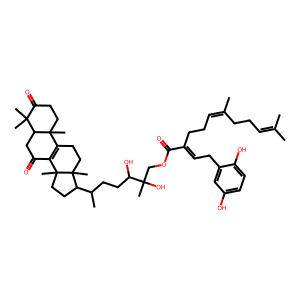

Prediction's cosine similarity to ground truth:  0.9066377282142639
idx is  0
________retival #1, cosine similarity to prediction: 0.907706081867218_________________
SMILES: CC(C)=CCCC(C)=CCCC(=CCc1cc(O)ccc1O)C(=O)OCC(C)(O)C(O)CCC(C)C1CCC2(C)C3=CCC4C(C)(C)C(=O)CCC4(C)C3=CCC12C
Name (24S,25R)-24,25-Dihydroxy-3-oxolanosta-7,9(11)-dien-27-yl (2Z,5E)-2-[2-(2,5-dihydroxyphenyl)ethylidene]-6,10-dimethyl-5,9-undecadienoate
Molecular weight 799.1459999999995


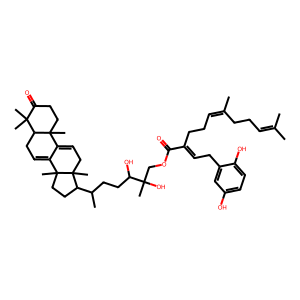

________retival #2, cosine similarity to prediction: 0.9066376090049744_________________
SMILES: CC(C)=CCCC(C)=CCCC(=CCc1cc(O)ccc1O)C(=O)OCC(C)(O)C(O)CCC(C)C1CCC2(C)C3=C(CCC12C)C1(C)CCC(=O)C(C)(C)C1CC3=O
Name (24S,25R)-24,25-Dihydroxy-3,7-dioxolanost-8-en-27-yl (2Z,5E)-2-[2-(2,5-dihydroxyphenyl)ethylidene]-6,10-dimethyl-5,9-undecadienoate
Molecular weight 815.1449999999994


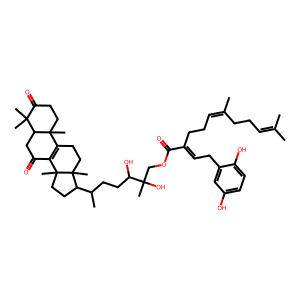

________retival #3, cosine similarity to prediction: 0.8725745677947998_________________
SMILES: CC(C)=CCCC(C)=CCCC(=CCc1cc(O)ccc1O)C(=O)OC(CCC(C)C1CCC2(C)C3=CCC4C(C)(C)C(=O)CCC4(C)C3=CCC12C)C(C)(O)CO
Name (17alpha,24S,25R)-25,26-Dihydroxy-3-oxolanosta-7,9(11)-dien-24-yl (2Z,5E)-2-[2-(2,5-dihydroxyphenyl)ethylidene]-6,10-dimethyl-5,9-undecadienoate
Molecular weight 799.1459999999998


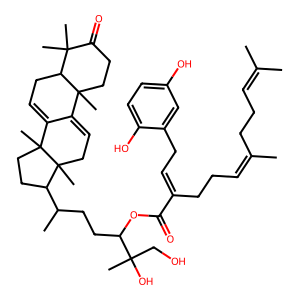

############################################### compound number: 2##############################################################
Ground Truth NMR
MW filter: [429.06791992187505, 643.6018798828125]
Chemical name Takanawaene A
Ground truth smiles CC1C=CC=CC=CC=CC=CC(O)CC(O)CC(O)CC(O)CCCC(O)CC(O)C(C)C(=O)OC1C


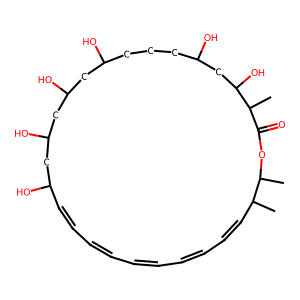

Prediction's cosine similarity to ground truth:  0.8973889946937561
idx is  1
________retival #1, cosine similarity to prediction: 0.971136212348938_________________
SMILES: CC1C=CC=CC=CC=CC=CC(O)C(C)C(O)CC(O)CC(O)CCCC(O)CC(O)C(C)C(=O)OC1C
Name AB023a
Molecular weight 550.7330000000004


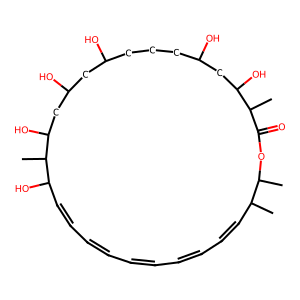

________retival #2, cosine similarity to prediction: 0.9168858528137207_________________
SMILES: CC1C=CC=CC=CC=CC=CC(O)C(C(=O)O)C(O)CC(O)CCCC(O)CC(O)CC(O)C(C)C(=O)OC1C
Name STREVERTENE A
Molecular weight 580.7150000000004


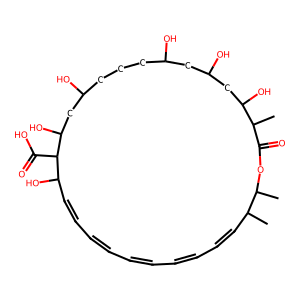

________retival #3, cosine similarity to prediction: 0.8973888158798218_________________
SMILES: CC1C=CC=CC=CC=CC=CC(O)CC(O)CC(O)CC(O)CCCC(O)CC(O)C(C)C(=O)OC1C
Name Takanawaene A
Molecular weight 536.7060000000001


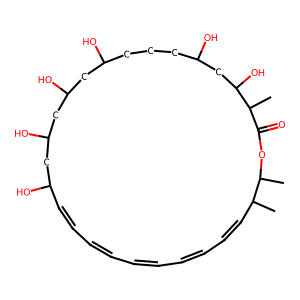

############################################### compound number: 3##############################################################
Ground Truth NMR
MW filter: [435.38461914062503, 653.0769287109375]
Chemical name UNPD91850
Ground truth smiles CC(=O)OCC1(O)C(O)CC(O)C2(C)C1C(OC(=O)c1ccccc1)C13CCC(C)=C1C2(O)C(=O)OC3(C)C


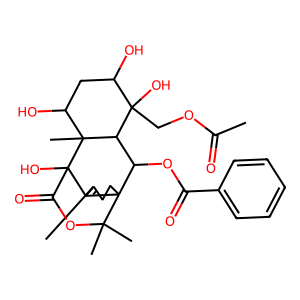

Prediction's cosine similarity to ground truth:  0.9052034616470337
idx is  2
________retival #1, cosine similarity to prediction: 0.9052034020423889_________________
SMILES: CC(=O)OCC1(O)C(O)CC(O)C2(C)C1C(OC(=O)c1ccccc1)C13CCC(C)=C1C2(O)C(=O)OC3(C)C
Name UNPD91850
Molecular weight 544.5970000000004


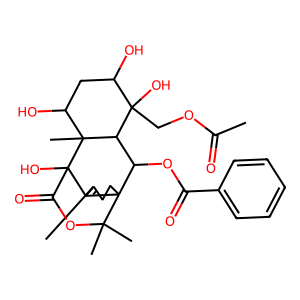

________retival #2, cosine similarity to prediction: 0.8658590316772461_________________
SMILES: CC1=C2C3(O)C(=O)OC(C)(C)C2(CC1)C(O)C1C(O)(CO)C(OC(=O)c2ccccc2)CC(O)C13C
Name UNPD12768
Molecular weight 502.56000000000023


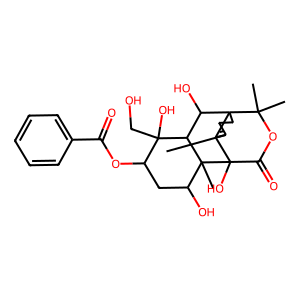

________retival #3, cosine similarity to prediction: 0.8613755702972412_________________
SMILES: CC1=C2C3(O)C(=O)OC(C)(C)C2(CC1)C(OC(=O)c1ccccc1)C1C(O)(CO)C(O)CC(O)C13C
Name (1s,2s,3r,4s,5s,7s,8s,9s)-4,5,7,9-tetrahydroxy-4-(hydroxymethyl)-8,11,14,14-tetramethyl-16-oxo-15-oxatetracyclo[7.4.3.0¹,¹⁰.0³,⁸]hexadec-10-en-2-yl benzoate
Molecular weight 502.5600000000002


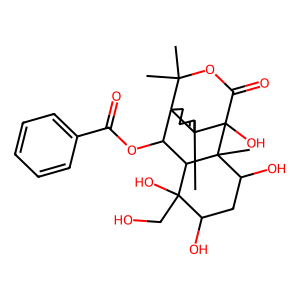

############################################### compound number: 4##############################################################
Ground Truth NMR
MW filter: [414.65952148437503, 621.9892822265625]
Chemical name asbestinin-16
Ground truth smiles C=C1CC2OC3C4C(CC(C)C(OC(C)=O)C24)C(C)COC3(C)C(OC(=O)CCCCCCC)CC1=O


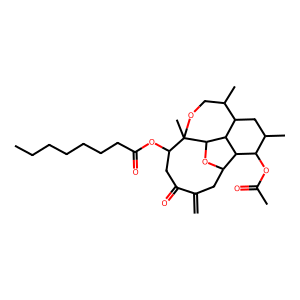

Prediction's cosine similarity to ground truth:  0.9742792844772339
idx is  3
________retival #1, cosine similarity to prediction: 0.9742791652679443_________________
SMILES: C=C1CC2OC3C4C(CC(C)C(OC(C)=O)C24)C(C)COC3(C)C(OC(=O)CCCCCCC)CC1=O
Name asbestinin-16
Molecular weight 518.6910000000005


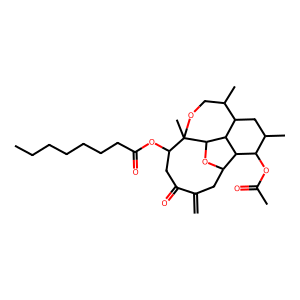

________retival #2, cosine similarity to prediction: 0.8989952802658081_________________
SMILES: C=C1CC2OC3C4C(CC(C)C(OC(=O)CCC)C24)C(C)COC3(C)C(OC(C)=O)CC1=O
Name UNPD169217
Molecular weight 462.58300000000025


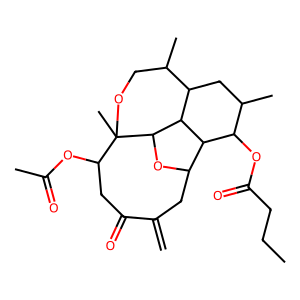

________retival #3, cosine similarity to prediction: 0.8762036561965942_________________
SMILES: C=C1CC2OC3C4C(CC(C)C(OC(C)=O)C24)C(C)COC3(C)C(OC(=O)CCCCCCC)CC1O
Name asbestinin-13
Molecular weight 520.7070000000006


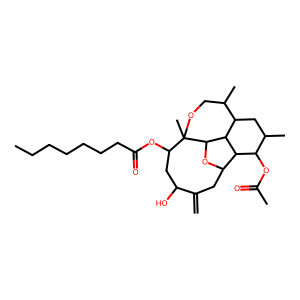

############################################### compound number: 5##############################################################
Ground Truth NMR
MW filter: [239.296630859375, 358.9449462890625]
Chemical name [(1E,6E)-7,11-Dimethyl-3-methylene-1,6,10-dodecatrien-1-yl]carbonimidic dichloride
Ground truth smiles C=C(C=CN=C(Cl)Cl)CCC=C(C)CCC=C(C)C


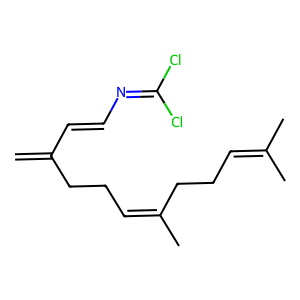

Prediction's cosine similarity to ground truth:  0.8657240867614746
idx is  4
________retival #1, cosine similarity to prediction: 0.9541434645652771_________________
SMILES: C=CC(=C)CCC=C(C)CCC=C(C)CCC=C(C)C
Name beta-Springene
Molecular weight 272.47599999999994


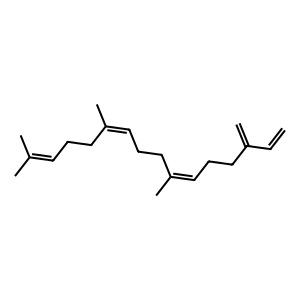

________retival #2, cosine similarity to prediction: 0.9541434645652771_________________
SMILES: C=CC(=C)CCC=C(C)CCC=C(C)CCC=C(C)CCC=C(C)C
Name "7,11,15,19-tetramethyl-3-methylene-icosa-1,6,10,14,18-pentaene"
Molecular weight 340.5950000000001


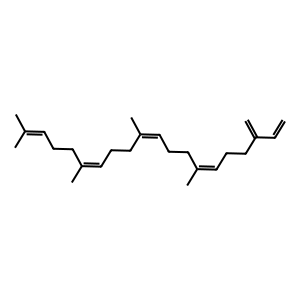

________retival #3, cosine similarity to prediction: 0.898026168346405_________________
SMILES: C=CC(C)=CCC=C(C)CCC=C(C)CCC=C(C)C
Name "3,7,11,15-tetramethylhexadeca-1,3,6,10,14-pentaene"
Molecular weight 272.47599999999994


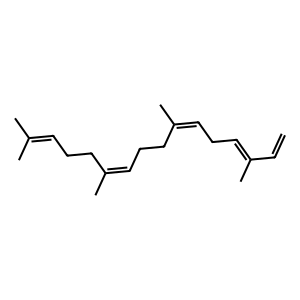

############################################### compound number: 6##############################################################
Ground Truth NMR
MW filter: [192.85911865234377, 289.28867797851564]
Chemical name Clausine N
Ground truth smiles COc1ccc2c(c1)[nH]c1ccc(C(=O)O)cc12


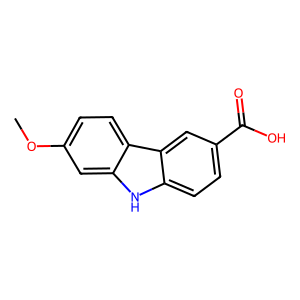

Prediction's cosine similarity to ground truth:  0.849992573261261
idx is  5
________retival #1, cosine similarity to prediction: 0.9131275415420532_________________
SMILES: COc1ccc2c(c1)[nH]c1cc(OC)ccc12
Name UNPD146163
Molecular weight 227.26299999999998


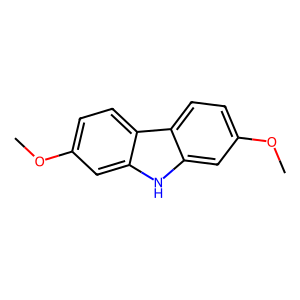

________retival #2, cosine similarity to prediction: 0.8632702827453613_________________
SMILES: COc1ccc2c(c1)[nH]c1ccc(C=O)cc12
Name Clauszoline K
Molecular weight 225.24699999999999


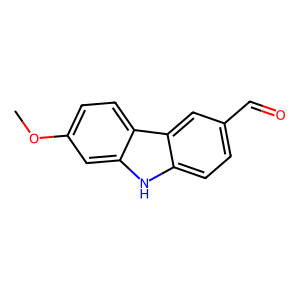

________retival #3, cosine similarity to prediction: 0.8499923944473267_________________
SMILES: COc1ccc2c(c1)[nH]c1ccc(C(=O)O)cc12
Name Clausine N
Molecular weight 241.24599999999998


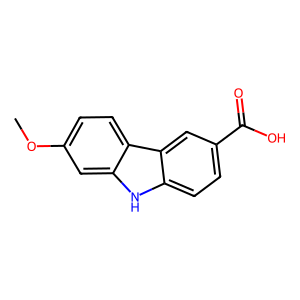

############################################### compound number: 7##############################################################
Ground Truth NMR
MW filter: [241.77968750000002, 362.66953125]
Chemical name 14191210
Ground truth smiles CC1(O)CC23C=CC1CC2C1(C)CCC(=O)C(C)(C)C1CC3


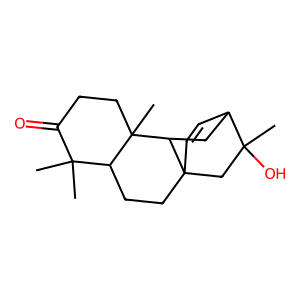

Prediction's cosine similarity to ground truth:  0.900407612323761
idx is  6
________retival #1, cosine similarity to prediction: 0.9004074335098267_________________
SMILES: CC1(O)CC23C=CC1CC2C1(C)CCC(=O)C(C)(C)C1CC3
Name 14191210
Molecular weight 302.4580000000001


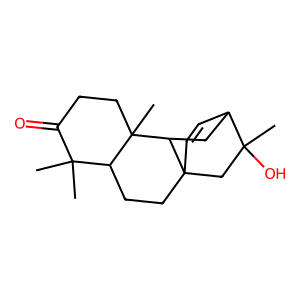

________retival #2, cosine similarity to prediction: 0.8862037658691406_________________
SMILES: CC12C=CC3(CCC4C(C)(C)C(=O)CCC4(C)C3CC1)C2
Name 15381927
Molecular weight 286.45900000000006


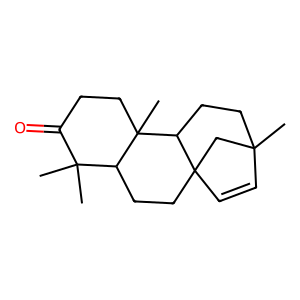

________retival #3, cosine similarity to prediction: 0.8645154237747192_________________
SMILES: CC12C=CC3(CCC4C(C)(C)C(=O)CCC4(C)C3CC1=O)C2
Name 14191181
Molecular weight 300.44200000000006


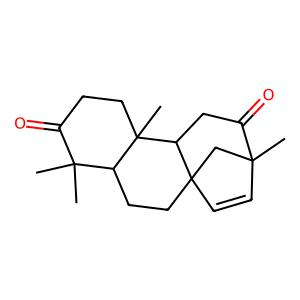

############################################### compound number: 8##############################################################
Ground Truth NMR
MW filter: [248.12551269531252, 372.1882690429687]
Chemical name 102014133
Ground truth smiles COc1cc2cc3c1OC(CCCC2)CCc1ccc(O)c-3c1


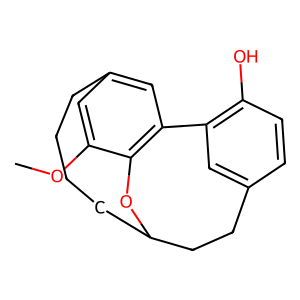

Prediction's cosine similarity to ground truth:  0.8453730344772339
idx is  7
________retival #1, cosine similarity to prediction: 0.8453727960586548_________________
SMILES: COc1cc2cc3c1OC(CCCC2)CCc1ccc(O)c-3c1
Name 102014133
Molecular weight 310.3929999999999


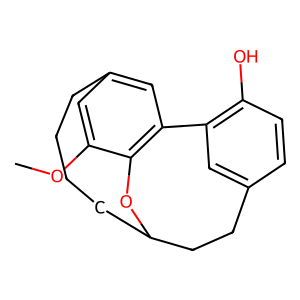

________retival #2, cosine similarity to prediction: 0.8369214534759521_________________
SMILES: COc1cc2cc(c1O)-c1cc(ccc1O)CCC(O)CCCC2
Name 44155973
Molecular weight 328.40800000000013


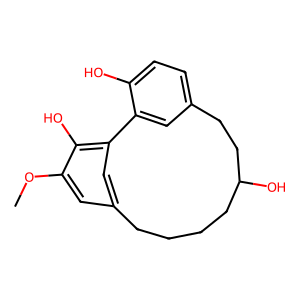

________retival #3, cosine similarity to prediction: 0.8351444005966187_________________
SMILES: COc1cc2cc3c1OC(CCCc1ccc(O)c-3c1)CCC2
Name "(11~{R})-17-methoxy-18-oxatetracyclo[9.6.1.1^{2,15}.1^{3,7}]icosa-1,3,5,7(20),15(19),16-hexaen-4-ol"
Molecular weight 310.3930000000001


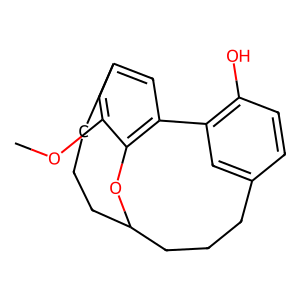

############################################### compound number: 9##############################################################
Ground Truth NMR
MW filter: [925.1867187500001, 1387.780078125]
Chemical name 197124
Ground truth smiles CSC1SCC2C(=O)N(C)C(C(C)C(C)C)C(=O)OCC(NC(=O)c3cnc4ccccc4n3)C(=O)NC(C)C(=O)N(C)C1C(=O)N(C)C(C(C)C(C)C)C(=O)OCC(NC(=O)c1cnc3ccccc3n1)C(=O)NC(C)C(=O)N2C


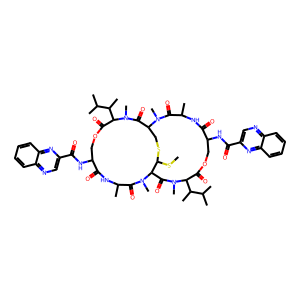

Prediction's cosine similarity to ground truth:  0.8487668037414551
idx is  8
________retival #1, cosine similarity to prediction: 0.8951886892318726_________________
SMILES: CSC1SCC2C(=O)N(C)C(C(C)C)C(=O)OCC(NC(=O)c3cnc4ccccc4n3)C(=O)NC(C)C(=O)N(C)C1C(=O)N(C)C(C(C)C)C(=O)OCC(NC(=O)c1cnc3ccccc3n1)C(=O)NC(C)C(=O)N2C
Name 3197
Molecular weight 1101.2789999999995


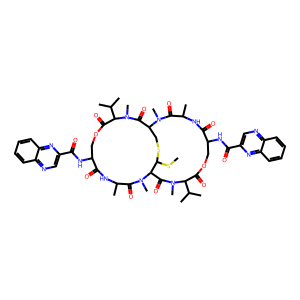

________retival #2, cosine similarity to prediction: 0.8944405317306519_________________
SMILES: CSC1C2C(=O)N(C)C(C(C)C)C(=O)OCC(NC(=O)c3cnc4ccccc4n3)C(=O)NC(C)C(=O)N(C)C(C[S+]1[O-])C(=O)N(C)C(C(C)C)C(=O)OCC(NC(=O)c1cnc3ccccc3n1)C(=O)NC(C)C(=O)N2C
Name "~{N}-[(4~{S},7~{R},11~{S},14~{R},17~{S},20~{R},24~{S},27~{S},28~{S})-11,24-diisopropyl-2,4,12,15,17,25-hexamethyl-27-methylsulfanyl-28-oxido-3,6,10,13,16,19,23,26-octaoxo-20-(quinoxaline-2-carbonylamino)-9,22-dioxa-28-thionia-2,5,12,15,18,25-hexazabicyclo[12.12.3]nonacosan-7-yl]quinoxaline-2-carboxamide"
Molecular weight 1117.2779999999996


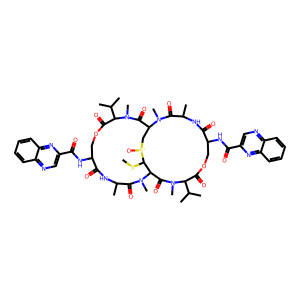

________retival #3, cosine similarity to prediction: 0.8927373886108398_________________
SMILES: CC1NC(=O)C(NC(=O)c2cnc3ccccc3n2)COC(=O)C(C(C)C)N(C)C(=O)C2CSSCC(C(=O)N(C)C(C(C)C)C(=O)OCC(NC(=O)c3cnc4ccccc4n3)C(=O)NC(C)C(=O)N2C)N(C)C1=O
Name N-[2,4,12,15,17,25-Hexamethyl-3,6,10,13,16,19,23,26-Octaoxo-11,24-Di(Propan-2-Yl)-20-(Quinoxaline-2-Carbonylamino)-9,22-Dioxa-28,29-Dithia-2,5,12,15,18,25-Hexazabicyclo[12.12.4]Triacontan-7-Yl]Quinoxaline-2-Carboxamide
Molecular weight 1087.2519999999995


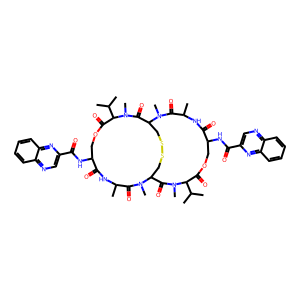

############################################### compound number: 10##############################################################
Ground Truth NMR
MW filter: [177.75871582031252, 266.63807373046876]
Chemical name 6432447
Ground truth smiles CC1(C)CCCC2(C)C3CCC2(C)C(O)C31


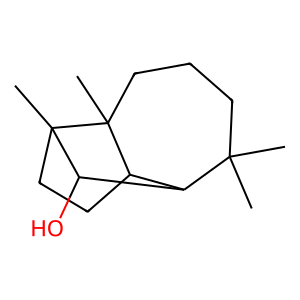

Prediction's cosine similarity to ground truth:  0.7170019149780273
idx is  9
________retival #1, cosine similarity to prediction: 0.7229759693145752_________________
SMILES: CC1(C)CCCC2(C)C(O)CC(O)C(O)C12
Name 4a,8,8-trimethyl-octahydronaphthalene-1,2,4-triol
Molecular weight 228.33200000000002


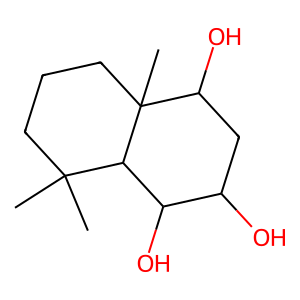

________retival #2, cosine similarity to prediction: 0.7213024497032166_________________
SMILES: CC12CCC(CC1O)C2(C)C1CCCCC1
Name "(1~{S},2~{R},4~{S},7~{S})-7-cyclohexyl-1,7-dimethyl-norbornan-2-ol"
Molecular weight 222.37199999999999


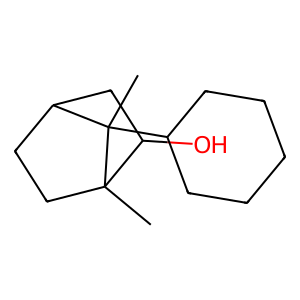

________retival #3, cosine similarity to prediction: 0.7170016765594482_________________
SMILES: CC1(C)CCCC2(C)C3CCC2(C)C(O)C31
Name 6432447
Molecular weight 222.37199999999999


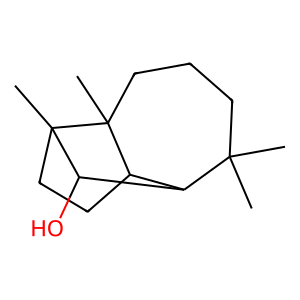

DONE






In [34]:
#### For infrastructure, this is cell can be skipped because i am not sharing my test-loader
'''
show some examples from my dataset to check sanity
for a single model, show top-5
'''

# for  which_compound in  random.sample(range(len(test_loader.dataset)), k=1):# range(0, 1):  
# for which_compound in range(0, 1):
for which_compound in range(10):
    
    print(f"############################################### compound number: {which_compound+1}##############################################################")
    
    for idx, batch in enumerate(test_loader):
        if idx < which_compound:
            continue
        inputs, extra_info = batch
        (smiles, names, NMR_type_indicator, path, np_class) = zip(*extra_info)
        # print(inputs.shape, inputs)
        # print(inputs, smiles_chemical_name)
        
        # batch[0] = batch[0].to("cuda")
        # hsqc, c_tensor, h_tensor = unpack_inputs_no_delimiter(inputs[0], NMR_type_indicator[0])
  
        inputs = inputs.to(model.device)
        NMR_type_indicator = NMR_type_indicator[0].to(model.device)
        pred = model(inputs, NMR_type_indicator)
        pred=torch.sigmoid(pred) # sigmoid
        pred_FP = torch.where(pred.squeeze()>0.5, 1, 0)
        # print(pred_FP.nonzero().squeeze().tolist())
        break
    # print(f"dataloader: {loader_all_inputs.dataset.latest_element_got}")
    
    # print(inputs)
    
    print("Ground Truth NMR")
    # plot_NMR(hsqc, c_tensor, h_tensor)
    mw_from_input = inputs[0][-1][0].item()
    MW_filter = [mw_from_input*0.8, mw_from_input*1.2]
    print(f"MW filter: {MW_filter}")
    topk = retrieve_top_k_by_rankingset(rankingset_data, pred, smiles_and_names, k=3, filter_by_MW=MW_filter)
    # topk = retrieve_top_k_by_rankingset(rankingset_data, pred, smiles_and_names, k=4, filter_by_MW=None)
    # ground truth
    # smiles, names, path = zip(*smiles_chemical_name)
    mol = Chem.MolFromSmiles(smiles[0])
    print(f"Chemical name {names[0]}")
    print(f"Ground truth smiles {smiles[0]}")
    # print(f"Ground truth NMR path {path[0]}")
    img = Draw.MolToImage(mol)
    img.show()
    
    ground_truth_FP = specific_radius_mfp_loader.build_mfp_for_new_SMILES(smiles[0])
    print("Prediction's cosine similarity to ground truth: ", compute_cos_sim(ground_truth_FP, pred.to("cpu").T.float()).item())
    # 
    i=0
    print("idx is ", idx)
    for value, (smile, name, mw , _), retrieved_FP in topk:
        print(f"________retival #{i+1}, cosine similarity to prediction: {value.item()}_________________")
        mol = Chem.MolFromSmiles(smile)
        # print("retrived FP", retrieved_FP.squeeze().tolist())

        print(f"SMILES: {smile}") 
        print(f"Name {name}")
        print(f"Molecular weight {mw}")
        img = Draw.MolToImage(mol)
        img.show()
        i+=1
        
print("DONE\n\n\n\n")
        



In [24]:
'''
temp feature:
compute rank-1 on inference set
'''
from tqdm import tqdm

rankingset_data = rankingset_data.to(model.device)
# for  which_compound in  random.sample(range(len(test_loader.dataset)), k=1):# range(0, 1):  
accu = [] 
    
for idx, batch in tqdm(enumerate(test_loader)):
        
    inputs, extra_info = batch
    (smiles, names, NMR_type_indicator, path, np_class) = zip(*extra_info)
    # print(inputs.shape, inputs)
    # print(inputs, smiles_chemical_name)
    
    # batch[0] = batch[0].to("cuda")
    # hsqc, c_tensor, h_tensor = unpack_inputs_no_delimiter(inputs[0], NMR_type_indicator[0])

    inputs = inputs.to(model.device)
    NMR_type_indicator = NMR_type_indicator[0].to(model.device)
    pred = model(inputs, NMR_type_indicator)
    pred=torch.sigmoid(pred) # sigmoid
    pred_FP = torch.where(pred.squeeze()>0.5, 1, 0)

    
    topk = retrieve_top_k_by_rankingset(rankingset_data, pred, smiles_and_names, k=1)
    # ground truth
    
    ground_truth_FP = specific_radius_mfp_loader.build_mfp_for_new_SMILES(smiles[0])
    # print("Prediction's cosine similarity to ground truth: ", compute_cos_sim(ground_truth_FP, pred.to("cpu").T.float()).item())
    # 
    i=0
    for value, (smile, name, _, _), retrieved_FP in topk:
        # print(f"________retival #{i+1}, cosine similarity to prediction: {value.item()}_________________")
        # mol = Chem.MolFromSmiles(smile)
        # # print("retrived FP", retrieved_FP.squeeze().tolist())

        # print(f"SMILES: {smile}") 
        # print(f"Name {name}")
        # img = Draw.MolToImage(mol)
        # img.show()
        # i+=1
        accu.append(smile == smiles[0])
        # accu.append(pred_FP.nonzero().squeeze().tolist() == retrieved_FP.to_dense().nonzero().squeeze().tolist())
        
        # accu.append(ground_truth_FP.nonzero().squeeze().tolist() == retrieved_FP.to_dense().nonzero().squeeze().tolist())
    # if smile == smiles[0]:
    #     break
    
print("DONE\n\n\n\n")

np.mean(accu)        



4056it [01:33, 43.22it/s]

DONE






np.float64(0.5739644970414202)

In [19]:
"""
Start  unkown compound
"""

'\nStart  unkown compound\n'

In [20]:
# look for the higher cos_sim possible in our dataset
def  retrieve_based_on_groudth(groud_truth_FP, k=5):
    topk = retrieve_top_k_by_rankingset(rankingset_data, groud_truth_FP, smiles_and_names, k=k) 
    
    i=0
    for ite, (value, (smile, name, _, _), retrieved_FP) in enumerate(topk):
        print(f"____________________________retival #{i+1}, cosine similarity: {value.item()}_____________________________")
        mol = Chem.MolFromSmiles(smile)
        print("retrived FP", retrieved_FP.to_dense().squeeze().tolist())
        print(f"SMILES: {smile}")
        print(f"Name {name}")
        #check is path file exists
        # plot_NMR(hsqc, c_tensor, h_tensor)
        img = Draw.MolToImage(mol)
        img.show()
        i+=1

In [21]:
Kavaratamide_A_SMILES = "CCCCCCC[C@H](O)CC(=O)N[C@@H](C(C)C)C(=O)N(C)[C@@H](C)C(=O)O[C@@H](C(C)C)C(=O)N1[C@@H](C(C)C)C(OC)=CC1=O"
Kavaratamide_A_FP = specific_radius_mfp_loader.build_mfp_for_new_SMILES(Kavaratamide_A_SMILES)

newCompoundA_SMILES = "O=C1C(NC2=O)CCC(O)N1C(CC3=CC=CC=C3)C(N(C)C(CC4=CC(Br)=C(O)C=C4)C(NC(C(CC)C)C(OC(C)C(C(NC2CCCC[NH3+])=O)NC(C(NC(C(COS(=O)([O-])=O)OC)=O)CC5=CC=CC=C5)=O)=O)=O)=O"
newCompoundA_FP = specific_radius_mfp_loader.build_mfp_for_new_SMILES(newCompoundA_SMILES)

Kavaratamide_A


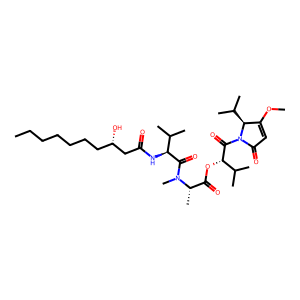

In [22]:
print("Kavaratamide_A")
mol = Chem.MolFromSmiles(Kavaratamide_A_SMILES)
img = Draw.MolToImage(mol)
img.show()

____________________________retival #1, cosine similarity: 0.70668625831604_____________________________
retrived FP [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05773502215743065, 0.05773502215743065, 0.05773502215743065, 0.0, 0.0, 0.0, 0.0, 0.05773502215743065, 0.0, 0.0, 0.05773502215743065, 0.0, 0.0, 0.05773502215743065, 0.0, 0.05773502215743065, 0.05773502215743065, 0.05773502215743065, 0.05773502215743065, 0.05773502215743065, 0.05773502215743065, 0.05773502215743065, 0.05773502215743065, 0.05773502215743065, 0.05773502215743065, 0.05773502215743065, 0.05773502215743065, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05773502215743065, 0.0, 0.05773502215743065, 0.0, 0.0, 0.05773502215743065, 0.0, 0.0, 0.05773502215743065, 0.05773502215743065, 0.05773502215743065, 0.05773502215743065, 0.05773502215743065, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05773502215743065, 0.05773502215743065, 0.05773502215743065, 0.05773502215743065, 0.0, 0.05773502215743065, 0.0, 0.05773502215743065, 0.0, 0.05773502

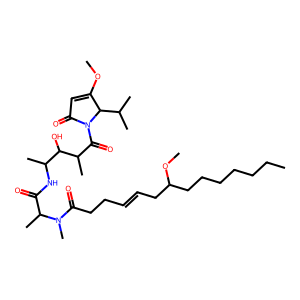

____________________________retival #2, cosine similarity: 0.622870922088623_____________________________
retrived FP [0.0, 0.0, 0.0, 0.0, 0.05852057412266731, 0.05852057412266731, 0.05852057412266731, 0.05852057412266731, 0.05852057412266731, 0.05852057412266731, 0.0, 0.0, 0.0, 0.0, 0.05852057412266731, 0.0, 0.0, 0.05852057412266731, 0.0, 0.05852057412266731, 0.05852057412266731, 0.0, 0.05852057412266731, 0.05852057412266731, 0.05852057412266731, 0.0, 0.0, 0.0, 0.05852057412266731, 0.05852057412266731, 0.05852057412266731, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05852057412266731, 0.05852057412266731, 0.05852057412266731, 0.05852057412266731, 0.05852057412266731, 0.05852057412266731, 0.0, 0.0, 0.05852057412266731, 0.0, 0.0, 0.05852057412266731, 0.05852057412266731, 0.05852057412266731, 0.05852057412266731, 0.05852057412266731, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05852057412266731, 0.05852057412266731, 0.05852057412266731, 0.05852057412266731, 0.0, 0.05852057412266731, 0.0, 0.0

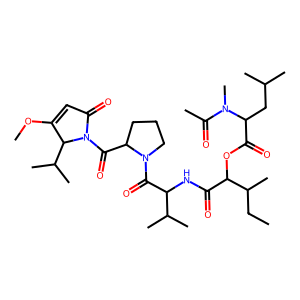

In [23]:
retrieve_based_on_groudth(Kavaratamide_A_FP.unsqueeze(dim=0).to("cuda"), k=2)




Kavaratamide A


_________________________________________________________
Prediction's cosine similarity to ground truth:  tensor(0.3445999920)



________retival #1, cosine similarity to prediction: 0.5450107455253601_________________
________retival's   cosine similarity to ground truth:  0.30245012044906616
SMILES: CC(O)C1CC1
Name ['1-cyclopropylethanol']


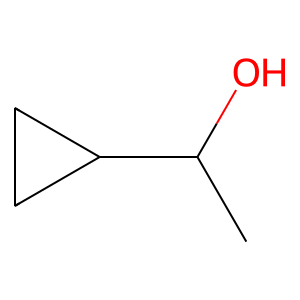

________retival #2, cosine similarity to prediction: 0.544002890586853_________________
________retival's   cosine similarity to ground truth:  0.30188125371932983
SMILES: CC(O)C(F)(F)F
Name ['1,1,1-trifluoro-2-propanol']


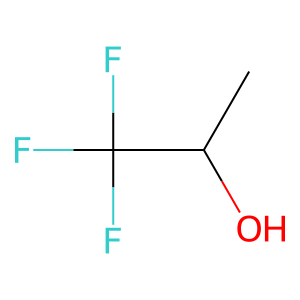

________retival #3, cosine similarity to prediction: 0.5317862629890442_________________
________retival's   cosine similarity to ground truth:  0.27617791295051575
SMILES: CC(O)C1[NH2+]CC(O)C1O.[Cl-]
Name ['pyrrolidine-(1-hydroxyethyl)-3,4-diol hydrochloride']


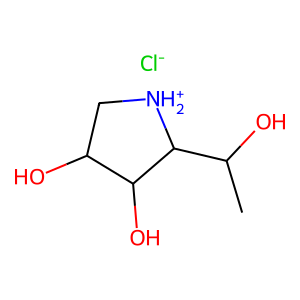

(['CC(O)C1CC1', 'CC(O)C(F)(F)F', 'CC(O)C1[NH2+]CC(O)C1O.[Cl-]'],
 [['1-cyclopropylethanol'],
  ['1,1,1-trifluoro-2-propanol'],
  ['pyrrolidine-(1-hydroxyethyl)-3,4-diol hydrochloride']])

In [24]:
compound_dir = "/root/gurusmart/MorganFP_prediction/inference_data/testing_compounds/Kavaratamide A"
mode = None#"flip_sign"
inputs, NMR_type_indicator = build_input(compound_dir, mode=mode,
                     include_h_nmr=True, include_c_nmr=True, include_hsqc=True,
                     )
inference_topK(inputs, NMR_type_indicator, model, rankingset_data, smiles_and_names, 
                   k=3, mode = None, ground_truth_FP=Kavaratamide_A_FP,
                   fp_type = "MFP_Specific_Radius", filter_by_MW="from_input")
                   

In [25]:
def investigate_new_molecule(compound_dir, SMILES):
    return
    mode = None#"flip_sign"

    # for model_type in ["only_1d_DTD", "only_C-NMR_DTD"]:
    for model_type in ['All-NMR', 'HSQC', 'C-NMR', 'H-NMR', 'HSQC_C-NMR', 'HSQC_H-NMR', 'only_1d', "only_1d_DTD", "only_C-NMR_DTD"]:
    # for model_type in ['All-NMR']:
    # for model_type in ['C-NMR', ]:
        
        kwargs = {
            "include_h_nmr" : model_type in ['All-NMR', 'H-NMR', 'HSQC_H-NMR', 'only_1d', "only_1d_DTD"],
            "include_c_nmr" : model_type in ['All-NMR', 'C-NMR', 'HSQC_C-NMR', 'only_1d', "only_1d_DTD", "only_C-NMR_DTD"],
            "include_hsqc" : model_type in ['All-NMR', 'HSQC', 'HSQC_C-NMR', 'HSQC_H-NMR', ]
        }
        
        inputs, NMR_type_indicator = build_input(compound_dir, mode=mode, **kwargs)
        
        hparams, model, test_loader = choose_model(model_type)
        max_radius = specific_radius_mfp_loader.max_radius
        print(f"Model type: {model_type}, max_radius: {max_radius}")
        rankingset_path = f"/root/gurusmart/MorganFP_prediction/inference_data/inference_rankingset_with_stable_sort/max_radius_{max_radius}_stacked_together_sparse/FP.pt"
        rankingset_data = torch.load(rankingset_path)#.to("cuda")
        
        save_molecule_inference(SMILES, compound_dir.split("/")[-1], None, model, model_type, inputs, NMR_type_indicator, rankingset_data, smiles_and_names)

In [26]:
compound_dir = "/root/gurusmart/MorganFP_prediction/inference_data/testing_compounds/Kavaratamide A"
Kavaratamide_A_SMILES = "CCCCCCC[C@H](O)CC(=O)N[C@@H](C(C)C)C(=O)N(C)[C@@H](C)C(=O)O[C@@H](C(C)C)C(=O)N1[C@@H](C(C)C)C(OC)=CC1=O"

investigate_new_molecule(compound_dir, Kavaratamide_A_SMILES)

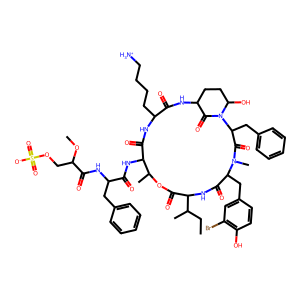

Error in O=C1C(NC2=O)CCC(O)N1C(CC3=CC=CC=C3)C(N(C)C(CC4=CC(Br)=C(O)C=C4)C(NC(C(CC)C)C(OC(C)C(C(NC2CCCC[NH3+])=O)NC(C(NC(C(COS(=O)([O-])=O)OC)=O)CC5=CC=CC=C5)=O)=O)=O)=O
Expecting value: line 1 column 1 (char 0)


(['unknown'], None)

In [27]:
# retrieve_based_on_groudth(newCompoundA_FP.unsqueeze(dim=0).to("cuda"), k=5)
newCompoundA_SMILES = "O=C1C(NC2=O)CCC(O)N1C(CC3=CC=CC=C3)C(N(C)C(CC4=CC(Br)=C(O)C=C4)C(NC(C(CC)C)C(OC(C)C(C(NC2CCCC[NH3+])=O)NC(C(NC(C(COS(=O)([O-])=O)OC)=O)CC5=CC=CC=C5)=O)=O)=O)=O"
Draw.MolToImage(Chem.MolFromSmiles(newCompoundA_SMILES)).show()
get_superclass_and_glycoside(newCompoundA_SMILES)

____________________________retival #1, cosine similarity: 0.7940562963485718_____________________________
retrived FP [0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.0, 0.0, 0.0, 0.0, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.045501574873924255, 0.0, 0.045501574873924255, 0.0, 0.0, 0.045501574873924255, 0.0, 0.0, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.0, 0.0, 0.0, 0.0, 0.0, 0.045501574873924255, 0.045501574873924255, 0.045501574873924255, 0.0455

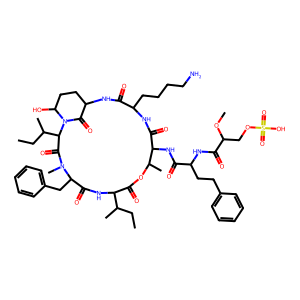

____________________________retival #2, cosine similarity: 0.7912123203277588_____________________________
retrived FP [0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0, 0.0, 0.0, 0.0, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0447661466896534, 0.0447661466896534, 0.0447661466896534, 0.04476614

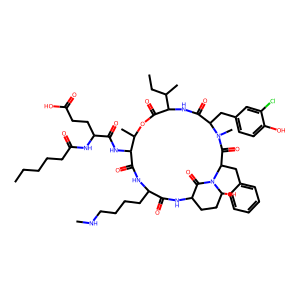

In [28]:
retrieve_based_on_groudth(newCompoundA_FP.unsqueeze(dim=0).to("cuda"), k=2)




new_compound_A


_________________________________________________________
Prediction's cosine similarity to ground truth:  tensor(0.6962741017)



________retival #1, cosine similarity to prediction: 0.7390384674072266_________________
________retival's   cosine similarity to ground truth:  0.7940567135810852
SMILES: CCC(C)C1NC(=O)C(Cc2ccccc2)N(C)C(=O)C(C(C)CC)N2C(=O)C(CCC2O)NC(=O)C(CCCCN)NC(=O)C(NC(=O)C(CCc2ccccc2)NC(=O)C(COS(=O)(=O)O)OC)C(C)OC1=O
Name Oscillapeptin F


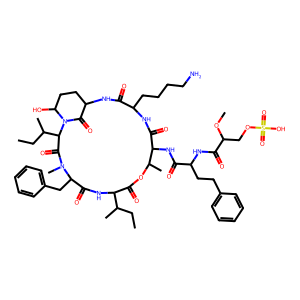

________retival #2, cosine similarity to prediction: 0.7365040183067322_________________
________retival's   cosine similarity to ground truth:  0.7166699171066284
SMILES: CCC(C)C1NC(=O)C(Cc2ccccc2)N(C)C(=O)C(C(C)O)N2C(=O)C(CCC2O)NC(=O)C(Cc2ccc(O)cc2)NC(=O)C(NC(=O)C(CCC(N)=O)NC(=O)C(O)Cc2ccc(O)cc2)C(C)OC1=O
Name 23724561


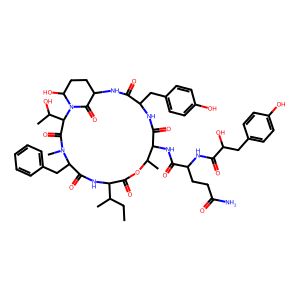

________retival #3, cosine similarity to prediction: 0.7350831031799316_________________
________retival's   cosine similarity to ground truth:  0.6990599632263184
SMILES: CCC(C)C1NC(=O)C(Cc2ccccc2)N(C)C(=O)C(C(C)O)N2C(=O)C(CCC2O)NC(=O)C(Cc2ccc(O)cc2)NC(=O)C(NC(=O)C(CCC(N)=O)NC(=O)C(NC(=O)C(O)Cc2ccc(O)cc2)C(C)O)C(C)OC1=O
Name 23724559


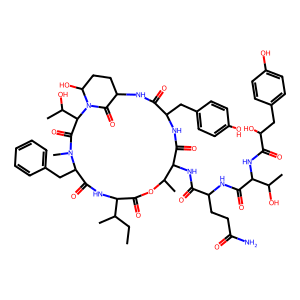

(['CCC(C)C1NC(=O)C(Cc2ccccc2)N(C)C(=O)C(C(C)CC)N2C(=O)C(CCC2O)NC(=O)C(CCCCN)NC(=O)C(NC(=O)C(CCc2ccccc2)NC(=O)C(COS(=O)(=O)O)OC)C(C)OC1=O',
  'CCC(C)C1NC(=O)C(Cc2ccccc2)N(C)C(=O)C(C(C)O)N2C(=O)C(CCC2O)NC(=O)C(Cc2ccc(O)cc2)NC(=O)C(NC(=O)C(CCC(N)=O)NC(=O)C(O)Cc2ccc(O)cc2)C(C)OC1=O',
  'CCC(C)C1NC(=O)C(Cc2ccccc2)N(C)C(=O)C(C(C)O)N2C(=O)C(CCC2O)NC(=O)C(Cc2ccc(O)cc2)NC(=O)C(NC(=O)C(CCC(N)=O)NC(=O)C(NC(=O)C(O)Cc2ccc(O)cc2)C(C)O)C(C)OC1=O'],
 ['Oscillapeptin F', '23724561', '23724559'])

In [29]:
mode = None#"flip_sign"
compound_dir = "/root/gurusmart/MorganFP_prediction/inference_data/testing_compounds/new_compound_A"

inputs, NMR_type_indicator = build_input(compound_dir, mode=mode,
                     include_h_nmr=False, include_c_nmr=False, include_hsqc=True,
                     )
inference_topK(inputs, NMR_type_indicator, model, rankingset_data, smiles_and_names, 
                   k=3, mode = None, ground_truth_FP=newCompoundA_FP, filter_by_MW="from_input",
                   fp_type = "MFP_Specific_Radius")

In [30]:
compound_dir = "/root/gurusmart/MorganFP_prediction/inference_data/testing_compounds/new_compound_A"
investigate_new_molecule(compound_dir, newCompoundA_SMILES)




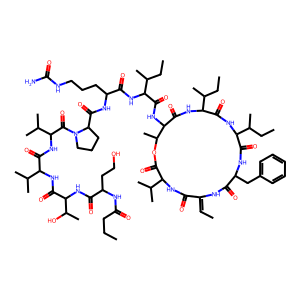

(['Oligopeptides'], False)

In [31]:
new_compoundB_smiles = "CCC(C1C(NC(C(C)CC)C(NC(CC2=CC=CC=C2)C(N/C(C(NC(C(C)C)C(OC(C)C(NC(C(NC(C(NC(C3CCCN3C(C(NC(C(NC(C(NC(C(NC(CCC)=O)CCO)=O)C(O)C)=O)C(C)C)=O)C(C)C)=O)=O)CCCNC(N)=O)=O)C(CC)C)=O)C(N1)=O)=O)=O)=C\C)=O)=O)=O)C"
Draw.MolToImage(Chem.MolFromSmiles(new_compoundB_smiles)).show()
get_superclass_and_glycoside(new_compoundB_smiles)

____________________________retival #1, cosine similarity: 0.9056555032730103_____________________________
retrived FP [0.0, 0.0, 0.0, 0.0, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.0, 0.0, 0.0, 0.0, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0.04307305067777634, 0

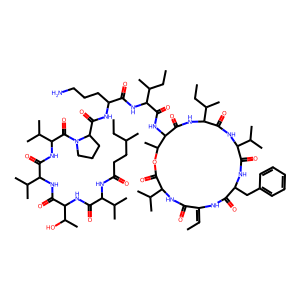

In [32]:
newCompoundB_FP = specific_radius_mfp_loader.build_mfp_for_new_SMILES(new_compoundB_smiles)
retrieve_based_on_groudth(newCompoundB_FP.unsqueeze(dim=0).to("cuda"), k=1)

In [33]:
mode = None#"flip_sign"
compound_dir = "/root/gurusmart/MorganFP_prediction/inference_data/testing_compounds/new_compound_B1"

inputs, NMR_type_indicator = build_input(compound_dir, mode=mode,
                     include_h_nmr=True, include_c_nmr=True, include_hsqc=True,
                     )
inference_topK(inputs, NMR_type_indicator, model, rankingset_data, smiles_and_names, 
                   k=10, mode = None, ground_truth_FP=newCompoundB_FP, filter_by_MW="from_input",
                   fp_type = "MFP_Specific_Radius")




new_compound_B1


_________________________________________________________
Prediction's cosine similarity to ground truth:  tensor(0.3379623592)





([], [])




new_compound_B2


_________________________________________________________
Prediction's cosine similarity to ground truth:  tensor(0.6738681197)



________retival #1, cosine similarity to prediction: 0.7387794852256775_________________
________retival's   cosine similarity to ground truth:  0.5272873044013977
SMILES: CCC(C)C1NC(=O)C(CSSCC2NC(=O)C(Cc3ccccc3)NC(=O)C3CCCN3C(=O)C3CCCN3C(=O)C(C(C)C)NC(=O)C(C(C)CC)NC2=O)NC(=O)C(Cc2ccccc2)NC(=O)C2CCCN2C(=O)C2CCCN2C(=O)C(C(C)C)NC1=O
Name "(3~{S},9~{S},12~{S},15~{S},18~{S},21~{S})-18-benzyl-15-[[[(3~{S},9~{S},12~{S},15~{S},18~{S},21~{S})-18-benzyl-9-isopropyl-12-[(1~{S})-1-methylpropyl]-2,8,11,14,17,20-hexaoxo-1,7,10,13,16,19-hexazatricyclo[19.3.0.0^{3,7}]tetracosan-15-yl]methyldisulfanyl]methyl]-9-isopropyl-12-[(1~{S})-1-methylpropyl]-1,7,10,13,16,19-hexazatricyclo[19.3.0.0^{3,7}]tetracosane-2,8,11,14,17,20-hexone"


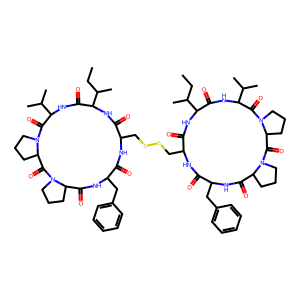

________retival #2, cosine similarity to prediction: 0.7213332653045654_________________
________retival's   cosine similarity to ground truth:  0.9056559801101685
SMILES: CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCC(C)CC)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O
Name "(2~{R})-~{N}-[(1~{S})-4-amino-1-[[(1~{R},2~{S})-1-[[(3~{S},6~{Z},9~{S},12~{R},15~{R},18~{R},19~{R})-9-benzyl-6-ethylidene-3,12-diisopropyl-19-methyl-15-[(1~{S})-1-methylpropyl]-2,5,8,11,14,17-hexaoxo-1-oxa-4,7,10,13,16-pentazacyclononadec-18-yl]carbamoyl]-2-methyl-butyl]carbamoyl]butyl]-1-[(2~{R})-2-[[(2~{S})-2-[[(2~{S},3~{R})-3-hydroxy-2-[[(2~{R})-3-methyl-2-[[(4~{S})-4-methylhexanoyl]amino]butanoyl]amino]butanoyl]amino]-3-methyl-butanoyl]amino]-3-methyl-butanoyl]pyrrolidine-2-carboxamide"


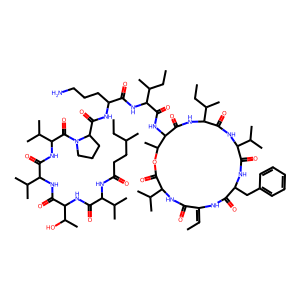

(['CCC(C)C1NC(=O)C(CSSCC2NC(=O)C(Cc3ccccc3)NC(=O)C3CCCN3C(=O)C3CCCN3C(=O)C(C(C)C)NC(=O)C(C(C)CC)NC2=O)NC(=O)C(Cc2ccccc2)NC(=O)C2CCCN2C(=O)C2CCCN2C(=O)C(C(C)C)NC1=O',
  'CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCC(C)CC)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O'],
 ['"(3~{S},9~{S},12~{S},15~{S},18~{S},21~{S})-18-benzyl-15-[[[(3~{S},9~{S},12~{S},15~{S},18~{S},21~{S})-18-benzyl-9-isopropyl-12-[(1~{S})-1-methylpropyl]-2,8,11,14,17,20-hexaoxo-1,7,10,13,16,19-hexazatricyclo[19.3.0.0^{3,7}]tetracosan-15-yl]methyldisulfanyl]methyl]-9-isopropyl-12-[(1~{S})-1-methylpropyl]-1,7,10,13,16,19-hexazatricyclo[19.3.0.0^{3,7}]tetracosane-2,8,11,14,17,20-hexone"',
  '"(2~{R})-~{N}-[(1~{S})-4-amino-1-[[(1~{R},2~{S})-1-[[(3~{S},6~{Z},9~{S},12~{R},15~{R},18~{R},19~{R})-9-benzyl-6-ethylidene-3,12-diisopropyl-19-methyl-15-[(1~{S})-1-methylpropyl]-2,5,8,11,14,17-hexaoxo-1-oxa-4,7,10,13,16-pentazacyclononadec-

In [34]:
compound_dir = "/root/gurusmart/MorganFP_prediction/inference_data/testing_compounds/new_compound_B2"

inputs, NMR_type_indicator = build_input(compound_dir, mode=mode,
                     include_h_nmr=False, include_c_nmr=False, include_hsqc=True,
                     )
inference_topK(inputs, NMR_type_indicator, model, rankingset_data, smiles_and_names, 
                   k=2, mode = None, ground_truth_FP=newCompoundB_FP, filter_by_MW="from_input",
                   fp_type = "MFP_Specific_Radius")

In [35]:
compound_dir = "/root/gurusmart/MorganFP_prediction/inference_data/testing_compounds/new_compound_B1"
# inputs, NMR_type_indicator = build_input(compound_dir,
#                      mode=mode,
#                      include_h_nmr=False, include_c_nmr=False
#                      )
# show_topK(inputs, k=3)

investigate_new_molecule(compound_dir, None)

In [36]:
compound_dir = "/root/gurusmart/MorganFP_prediction/inference_data/testing_compounds/new_compound_B2"


investigate_new_molecule(compound_dir, None)